In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Arabidopsis dataset example

This notebook follows the example in section 4.2 from  [`edgeR` user guide.](https://bioconductor.org/packages/release/bioc/html/edgeR.html). 
The data comes from Cumbie et al., 2011, and has been packaged by the `edgeR` team.
We have minimally pre-processed the dataset in line with how `edgeR` manual does this so the results are equivalent.

See [Data directory](../data/from-edger-user-guide/arabidopsis) for more information.


We are trying to reproduce the TMM normalisation (Robinson, 2010) as described in the `edgeR` guide:

```
> y <- calcNormFactors(y)
> y$samples
group lib.size norm.factors
mock1 mock 1882391 0.977
mock2 mock 1870625 1.023
mock3 mock 3227243 0.914
hrcc1 hrcc 2101449 1.058
hrcc2 hrcc 1243266 1.083
hrcc3 hrcc 3494821 0.955
```

This example will walk you through how these normalisation factors can be reproduced by the `tmma` package and will walk you through some other features of the package, such as visualisation.

## References

* Cumbie, J., Kimbrel, J., Di, Y., Schafer, D., Wilhelm, L., Fox, S., Sullivan, C., Curzon, A., Carrington, J., Mockler, T., Chang, J. (2011). GENE-Counter: A Computational Pipeline for the Analysis of RNA-Seq Data for Gene Expression Differences PLoS ONE 6(10), e25279. https://dx.doi.org/10.1371/journal.pone.0025279
* Robinson, M., McCarthy, D., Smyth, G. (2009). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data Bioinformatics  26(1), 139-140. https://dx.doi.org/10.1093/bioinformatics/btp616
* Robinson, M., Oshlack, A. (2010). A scaling normalization method for differential expression analysis of RNA-seq data Genome Biology  11(3), R25. https://dx.doi.org/10.1186/gb-2010-11-3-r25
* McCarthy, D., Chen, Y., Smyth, G. (2012). Differential expression analysis of multifactor RNA-Seq experiments with respect to biological variation Nucleic Acids Research  40(10), 4288-4297. https://dx.doi.org/10.1093/nar/gks042

First, let's load the data:

In [2]:
import pandas as pd
import numpy as np

arabidopsis = pd.read_csv('../data/from-edger-user-guide/arabidopsis/arab.csv', index_col=0)

In [3]:
arabidopsis.head()

,mock1,mock2,mock3,hrcc1,hrcc2,hrcc3
AT1G01010,35,77,40,46,64,60
AT1G01020,43,45,32,43,39,49
AT1G01030,16,24,26,27,35,20
AT1G01040,72,43,64,66,25,90
AT1G01050,49,78,90,67,45,60


Now we can load `tmma` package, where we have implemented a TMM normalisation procedure, benchmarking it to `edgeR`.
It gives consistent results with `edgeR` results up to two decimal points.
The variance comes from the issues in floating point calculations and their effects to ranking.

In [4]:
import tmma

To perform TMM normalisation one can simply use the function `tmm_normalisation`:

In [5]:
tmma.tmm_normalisation_factors(arabidopsis)

/Users/saulius.lukauskas/dev/short-investigations/tmm-py/src/tmma/ma/stats.py:42: RuntimeWarning: divide by zero encountered in log2
  log2_normed_obs = np.log2(obs) - np.log2(lib_size_obs)
/Users/saulius.lukauskas/dev/short-investigations/tmm-py/src/tmma/ma/stats.py:43: RuntimeWarning: divide by zero encountered in log2
  log2_normed_ref = np.log2(ref) - np.log2(lib_size_ref)
/Users/saulius.lukauskas/dev/short-investigations/tmm-py/src/tmma/ma/stats.py:46: RuntimeWarning: invalid value encountered in subtract
  m = log2_normed_obs - log2_normed_ref


mock1    0.977168
mock2    1.022845
mock3    0.914214
hrcc1    1.058449
hrcc2    1.082843
hrcc3    0.954856
dtype: float64

Note that this produces for all purposes the same results as the `edgeR` implementation. 
`edgeR` results are pasted below:

```
> y <- calcNormFactors(y)
> y$samples
group lib.size norm.factors
mock1 mock 1882391 0.977
mock2 mock 1870625 1.023
mock3 mock 3227243 0.914
hrcc1 hrcc 2101449 1.058
hrcc2 hrcc 1243266 1.083
hrcc3 hrcc 3494821 0.955
```

The warnings you see in red are due to our code being based on the `edgeR` implemenatation, 
which more often than not choses to divide by zero and deal with the resulting nan's or infinities later. 
We have adopted the same approach.

Unlike `edgeR`, our package also comes with some additional features, for instance, one can disable edgeR's default behaviour to make the scaling factors multiply to one:

In [6]:
tmma.tmm_normalisation_factors(arabidopsis, return_scaled=False)

mock1    1.023367
mock2    1.071203
mock3    0.957436
hrcc1    1.108491
hrcc2    1.134038
hrcc3    1.000000
dtype: float64

Note how `hrcc3` sample now has the scaling factor set to 1.0 as it was selected to be the reference sample by the procedure. This can be overriden:

In [7]:
tmma.tmm_normalisation_factors(arabidopsis, ref_column='mock1', return_scaled=False)

mock1    1.000000
mock2    1.014027
mock3    0.949017
hrcc1    1.080764
hrcc2    1.118844
hrcc3    0.977166
dtype: float64

Additionally, the TMM normalisation can be performed pairwise.
Code below will produce the `mock3`/`mock1` scaling factor `sf` 
s.t. `mock2 ~= mock1 * sf`

In [8]:
tmma.two_sample_tmm(arabidopsis['mock3'], arabidopsis['mock1'])

0.9490165068381654

The internals of the statistics are available for the users:

In [9]:
obs = arabidopsis['mock3']
ref = arabidopsis['mock1']

m_values, a_values = tmma.ma_statistics(obs, ref)
asymptotic_variances = tmma.asymptotic_variance(obs, ref)
kept_after_trim = tmma.tmm_trim_mask(m_values, a_values)

log2_sf = np.average(m_values[kept_after_trim], 
                     weights=1.0/asymptotic_variances[kept_after_trim])

sf = np.power(2, log2_sf)

sf

/Users/saulius.lukauskas/.virtualenvs/tmm-py/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/saulius.lukauskas/dev/short-investigations/tmm-py/src/tmma/ma/stats.py:89: RuntimeWarning: divide by zero encountered in true_divide
  av = (lib_size_obs - obs) / lib_size_obs / obs + (lib_size_ref - ref) / lib_size_ref / ref


0.9490165068381654

Having this break down allows us to visualise what the normalisation is doing:

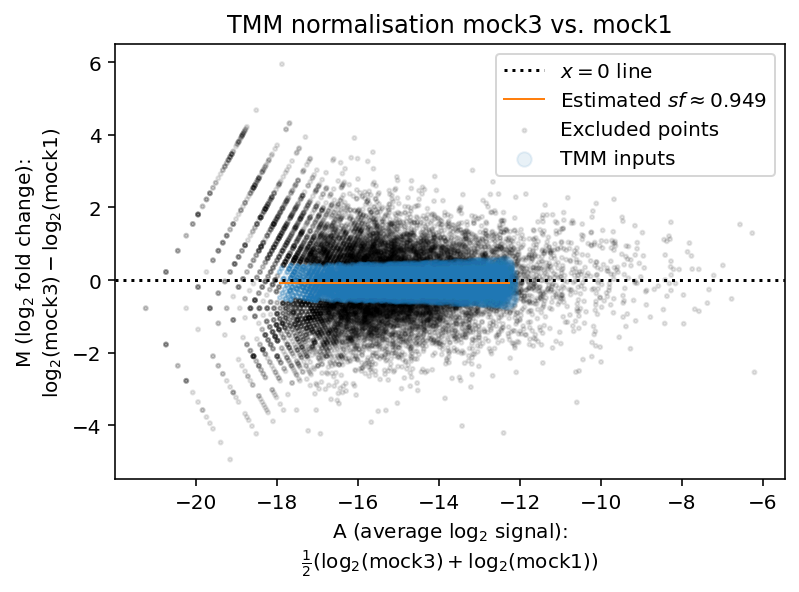

In [10]:
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

ax = plt.gca()

ax.axhline(0, linestyle=':', color='black', 
           label="$x=0$ line")

min_size = 4
max_size = 100

weights = 1.0 / asymptotic_variances
size_function = interp1d([weights[kept_after_trim].min(), 
                          weights[kept_after_trim].max()],
                         [min_size, max_size],
                         bounds_error=False,
                         fill_value='extrapolate'
                         )

sizes = size_function(weights)
sizes[~kept_after_trim] = min_size

scatter_kwargs = dict(alpha=.1, rasterized=True)

color_other = 'black'
ax.scatter(a_values[~kept_after_trim], 
           m_values[~kept_after_trim], 
           s=sizes[~kept_after_trim],
           color='black',
           label="Excluded points",
           **scatter_kwargs,
           )

color_tmm = next(ax._get_lines.prop_cycler)['color']
ax.scatter(a_values[kept_after_trim], 
           m_values[kept_after_trim], 
           s=sizes[kept_after_trim],
           color=color_tmm,
           label="TMM inputs",
           **scatter_kwargs
           )

color_tmm_line = next(ax._get_lines.prop_cycler)['color']
ax.plot([a_values[kept_after_trim].min(),
         a_values[kept_after_trim].max()],
         [np.log2(sf), np.log2(sf)],
         color=color_tmm_line,
         linewidth=1.0,
         label=r"Estimated $sf \approx {:.3f}$".format(sf))

xlabel = '\n'.join([
    r'A (average $\log_2$ signal):',
    r'$\frac{{1}}{{2}} \left( \log_2( \mathrm{{ {obs} }} ) + \log_2( \mathrm{{ {ref} }} ) \right)$'.format(obs=obs.name, ref=ref.name)
])

ylabel = '\n'.join([
    r'M ($\log_2$ fold change):', 
    r'$\log_2( \mathrm{{ {obs} }} ) - \log_2( \mathrm{{ {ref} }} )$'.format(obs=obs.name, ref=ref.name)
])


ax.set_title("TMM normalisation {obs} vs. {ref}".format(obs=obs.name, ref=ref.name))
                    
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.legend()

A helper function for these plots is implemented:

<AxesSubplot:title={'center':'TMM normalisation mock3 vs. mock1'}, xlabel='A (average $\\log_2$ signal):\n$\\frac{1}{2} \\left( \\log_2( \\mathrm{ mock3 } ) + \\log_2( \\mathrm{ mock1 } ) \\right)$', ylabel='M ($\\log_2$ fold change):\n$\\log_2( \\mathrm{ mock3 } ) - \\log_2( \\mathrm{ mock1 } )$'>

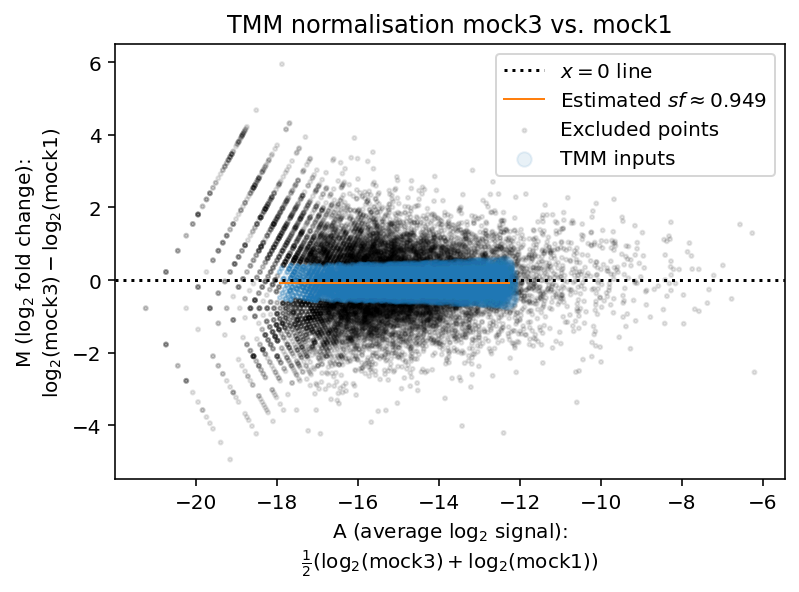

In [11]:
tmma.plot_two_sample_tmm(obs, ref)

Note that the blue area does not appear to be horizontal due to the scatterpoints on the right having larger sizes (as they have higher weights in TMM). You can run TMM without weighing which will make the blue area perfectly horizontal:

<AxesSubplot:title={'center':'TMM normalisation mock3 vs. mock1'}, xlabel='A (average $\\log_2$ signal):\n$\\frac{1}{2} \\left( \\log_2( \\mathrm{ mock3 } ) + \\log_2( \\mathrm{ mock1 } ) \\right)$', ylabel='M ($\\log_2$ fold change):\n$\\log_2( \\mathrm{ mock3 } ) - \\log_2( \\mathrm{ mock1 } )$'>

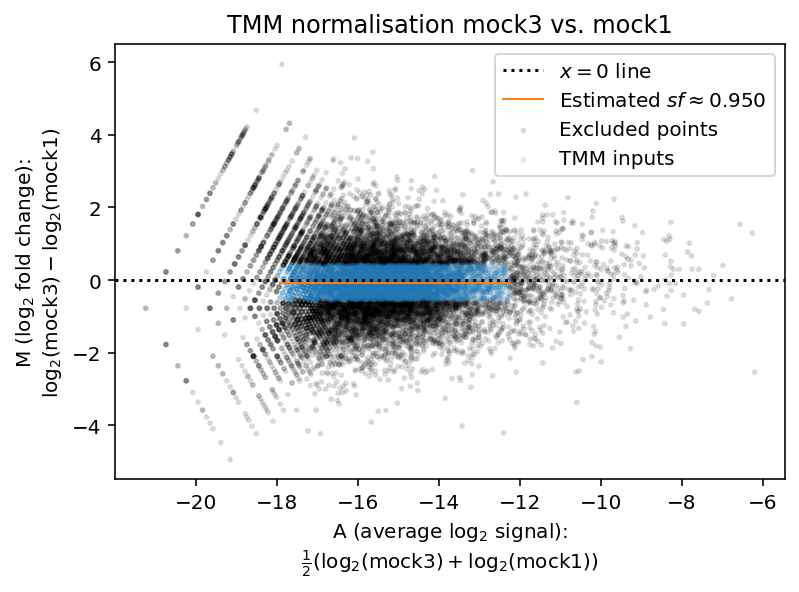

In [12]:
tmma.plot_two_sample_tmm(obs, ref, kw_tmm=dict(weighted=False))

Note a minor change in the scaling factor estimate above.

Besides weighting these plots are useful in investigating other parameters of TMM 
as in some cases it helps to do this optimisation.

For instance, see below is the plot with only 10% of M-values and 1% of A-values trimmed:

<AxesSubplot:title={'center':'TMM normalisation mock3 vs. mock1'}, xlabel='A (average $\\log_2$ signal):\n$\\frac{1}{2} \\left( \\log_2( \\mathrm{ mock3 } ) + \\log_2( \\mathrm{ mock1 } ) \\right)$', ylabel='M ($\\log_2$ fold change):\n$\\log_2( \\mathrm{ mock3 } ) - \\log_2( \\mathrm{ mock1 } )$'>

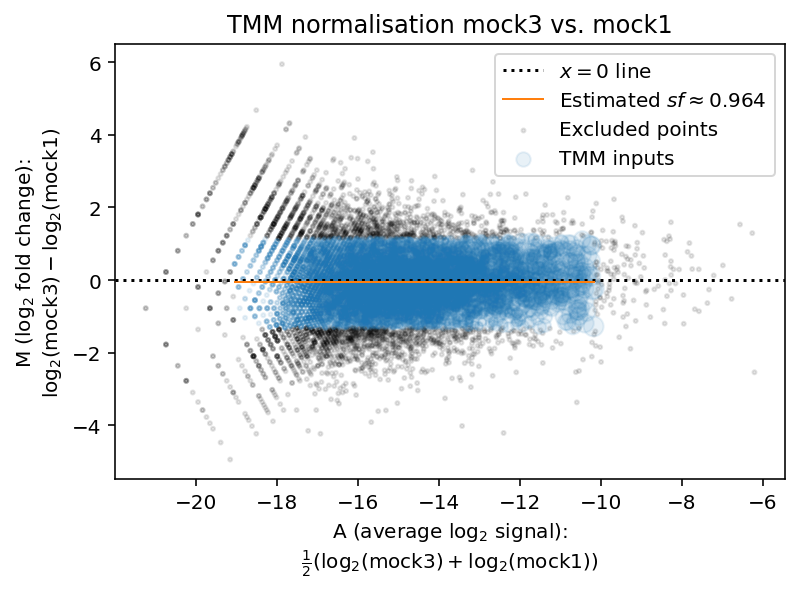

In [13]:
tmma.plot_two_sample_tmm(obs, ref, 
                         kw_tmm=dict(a_values_trim_fraction=0.01, 
                                     m_values_trim_fraction=0.1))

And that's it. Hope this example provides enough guidance for using the package.

In [14]:
from sinfo import sinfo
sinfo(write_req_file=False)

-----
matplotlib  3.3.1
numpy       1.19.2
pandas      1.1.2
scipy       1.5.2
sinfo       0.3.1
tmma        NA
-----
IPython             7.18.1
jupyter_client      6.1.7
jupyter_core        4.6.3
notebook            6.1.4
-----
Python 3.8.5 (default, Jul 21 2020, 10:42:08) [Clang 11.0.0 (clang-1100.0.33.17)]
macOS-10.14.6-x86_64-i386-64bit
8 logical CPU cores, i386
-----
Session information updated at 2020-09-17 21:43
